In [52]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import json
import os
import contextily as ctx

from adjustText import adjust_text
from shapely.geometry import Polygon

# Getting Data

## Hydrological Data

The list of stations used by the Federal Office of the environment can be found on this page: https://www.bafu.admin.ch/bafu/de/home/themen/wasser/daten-karten/wasser--messnetze/basismessnetz--wasserstand-und-abfluss-an-oberflaechengewaessern.html#46775952

In [21]:
station_list = pd.read_excel("data/Stationsliste_HydrowebSAM_DE_Juli2023.xlsx", skiprows=4)

# Restrict list to stations which are active, are part of the aare system and where discharge is measured
aare_stations = station_list[
    (station_list["Betriebsstatus"] == "in Betrieb") & 
    (station_list["Flussgebiet"] == "Aaregebiet") & 
    (station_list["Messparameter"]  == "Abfluss")
]

# convert to geopandas for ease of plot
aare_stations = gpd.GeoDataFrame(
    aare_stations,
    geometry=gpd.points_from_xy(x=aare_stations["X-Koordinate"], y=aare_stations["Y-Koordinate"]),
    crs='EPSG:2056'
)

aare_stations.head()

,Betriebsstatus,Flussgebiet,Stationsnr.,Gewässer,Stationsname,Gewässertyp,X-Koordinate,Y-Koordinate,Stationshöhe [m ü.M.],Einzugsgebietsfläche [km2],Mittlere Einzugsgebietshöhe [m ü.M.],Vergletscherungsanteil [%],Messparameter,Daten verfügbar ab,Daten verfügbar bis,geometry
2,in Betrieb,Aaregebiet,70,Emme,Emmenmatt,Fliessgewässer,2623616,1200426.0,641,443.0,1065.0,0.0,Abfluss,1909-01-01,heute,POINT (2623616 1200426)
4,in Betrieb,Aaregebiet,155,Emme,"Wiler, Limpachmündung",Fliessgewässer,2608228,1223238.0,459,937.0,858.0,0.0,Abfluss,1921-07-01,heute,POINT (2608228 1223238)
27,in Betrieb,Aaregebiet,488,Simme,Latterbach,Fliessgewässer,2610681,1167849.0,666,563.0,1594.0,1.5,Abfluss,1985-05-01,heute,POINT (2610681 1167849)
60,in Betrieb,Aaregebiet,2016,Aare,Brugg,Fliessgewässer,2656959,1259353.0,336,11681.0,1000.0,1.5,Abfluss,1916-01-01,heute,POINT (2656959 1259353)
70,in Betrieb,Aaregebiet,2019,Aare,Brienzwiler,Fliessgewässer,2649942,1177374.0,574,555.0,2135.0,15.5,Abfluss,1905-01-01,heute,POINT (2649942 1177374)


Choice (up for debate): Bern, Schönau as target which has `Stationsnr. = 2135`

<Axes: >

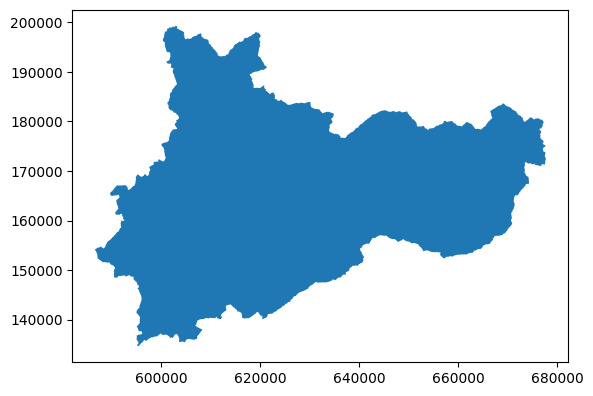

In [26]:
def get_catchment_geometry(station_no: str) -> gpd.GeoDataFrame | int:
    try:
        with urllib.request.urlopen(f"https://api3.geo.admin.ch/rest/services/api/MapServer/ch.bafu.hydrologie-hydromessstationen/{station_no}") as url:
            data = json.load(url)
            geometry = data.get('feature').get('geometry')
        # somewhat strong assumption: it seems, the geometry for all stations is defined as a ring - convert to shapely.Polygon
        catchment_geom = Polygon(geometry['rings'][0])
        catchment_geom = gpd.GeoDataFrame([{'geometry': catchment_geom}], crs="EPSG:21781") #EPSG:21781 the LV95 coordinate projection
        return catchment_geom
    except Exception as e:
        print(f"Something went wrong: {e}")
        return 0

catchment = get_catchment_geometry("2135")
catchment.plot()

In [29]:
# change the coordinate projection to the OpenStreetMap projection
catchment = catchment.to_crs(epsg=3857)
aare_stations = aare_stations.to_crs(epsg=3857)

# create a column whether a station is in catchment = is upriver 
aare_stations["in_catchment"] = aare_stations.geometry.apply(lambda geom: catchment.geometry[0].contains(geom))

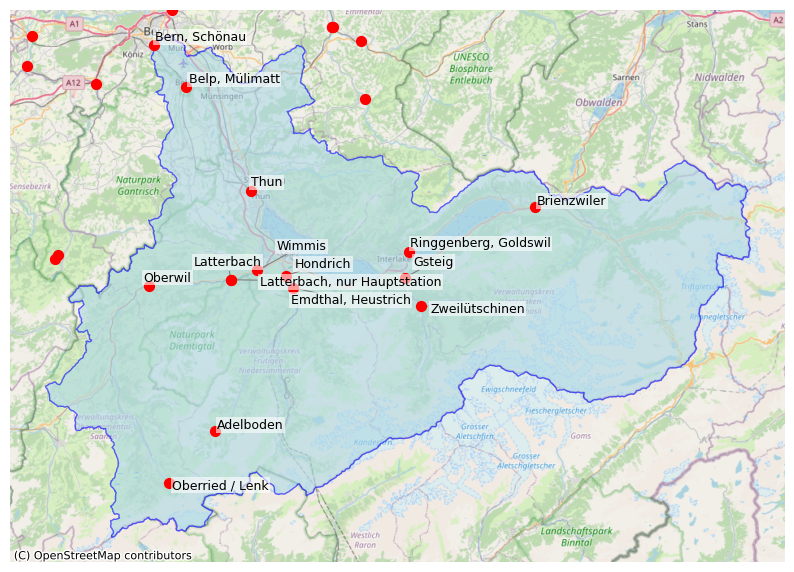

In [37]:
# Plot with map
fig, ax = plt.subplots(figsize=(10, 8))
catchment.plot(ax=ax, facecolor="lightblue", edgecolor="blue", alpha=0.6)

# Add basemap (OpenStreetMap tiles)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add hydrological stations and name those in catchment
aare_stations.plot(ax=ax, color="red", markersize=50, zorder=5)

texts = []
for idx, row in aare_stations[aare_stations["in_catchment"]==True].iterrows():
    texts.append(
        ax.text(
            row.geometry.x,
            row.geometry.y,
            row["Stationsname"],
            fontsize=9,
            color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1),
            zorder=6
        )
    )

# Adjust positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.8))


ax.set_axis_off()
plt.show()

Here follows the code to load the measurements at the named stations above. I'll think about how to share these

In [66]:
hydro = pd.read_csv("datasets/hydro/hydro-2024-upper-aare.csv")
hydro['value_scaled'] = hydro.groupby('station_name')['value'].transform(lambda x: x / x.mean())
hydro.head()


,station_name,station_latitude,station_longitude,parametertype_name,ts_unitsymbol,station_id,timestamp,value,value_scaled
0,"Belp, Mülimatt",46.885212,7.501793,Abfluss,m3/s,5053080,2020-04-01 00:00:00.000000 UTC,1.535,0.73206
1,"Belp, Mülimatt",46.885212,7.501793,Abfluss,m3/s,5053080,2020-04-01 00:10:00.000000 UTC,1.535,0.73206
2,"Belp, Mülimatt",46.885212,7.501793,Abfluss,m3/s,5053080,2020-04-01 00:20:00.000000 UTC,1.535,0.73206
3,"Belp, Mülimatt",46.885212,7.501793,Abfluss,m3/s,5053080,2020-04-01 00:30:00.000000 UTC,1.535,0.73206
4,"Belp, Mülimatt",46.885212,7.501793,Abfluss,m3/s,5053080,2020-04-01 00:40:00.000000 UTC,1.535,0.73206


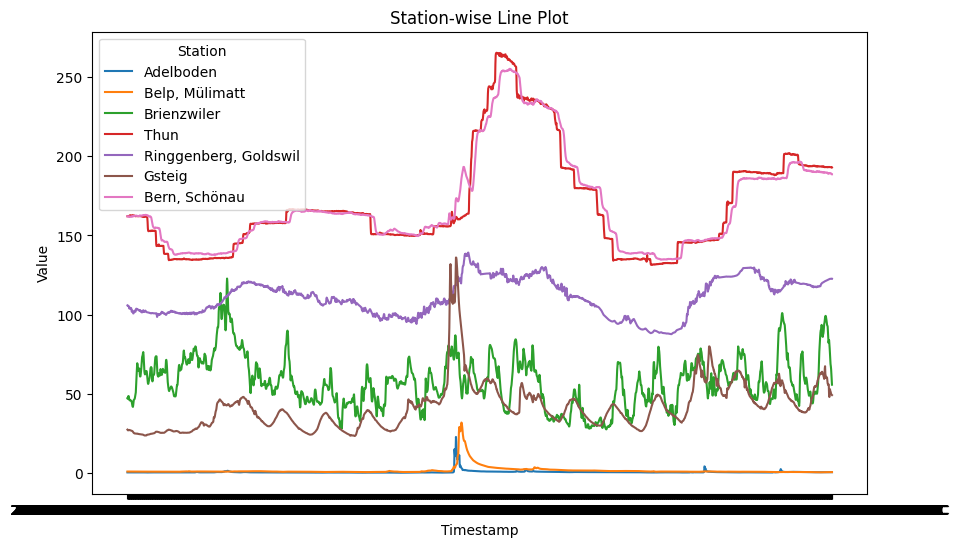

In [3]:
start_date = '2020-07-15'
end_date = '2020-08-01'

# Filter data
month_df = hydro[(hydro['timestamp'] >= start_date) & (hydro['timestamp'] <= end_date)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=month_df, x='timestamp', y='value', hue='station_name')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Station-wise Line Plot')
plt.legend(title='Station')
plt.show()


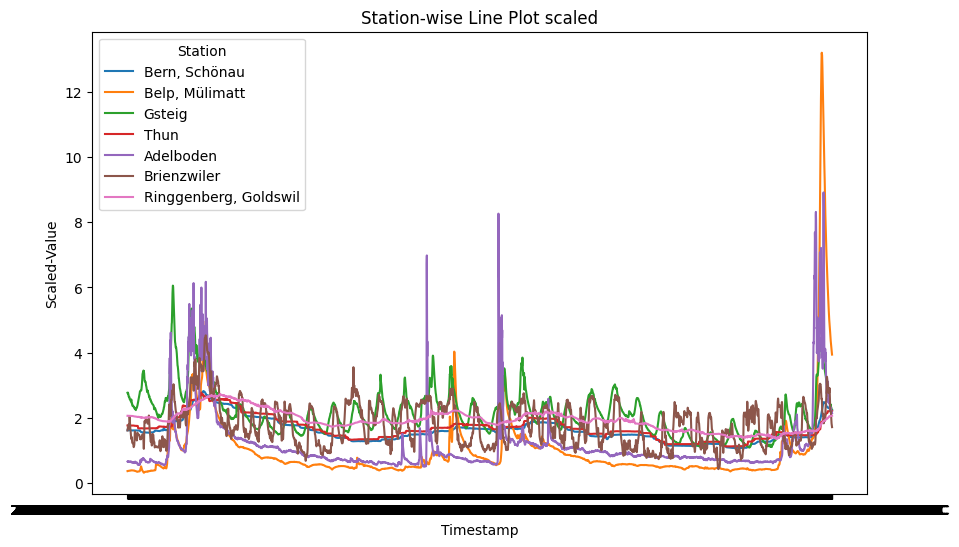

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=month_df, x='timestamp', y='value_scaled', hue='station_name')

plt.xlabel('Timestamp')
plt.ylabel('Scaled-Value')
plt.title('Station-wise Line Plot scaled')
plt.legend(title='Station')
plt.show()

## Meteorological stations

In [49]:
meteo_stations = pd.read_csv("https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/ogd-smn-precip_meta_stations.csv", sep=';', encoding='latin-1')

meteo_stations = gpd.GeoDataFrame(
    meteo_stations,
    geometry=gpd.points_from_xy(x=meteo_stations.station_coordinates_lv95_east, y=meteo_stations.station_coordinates_lv95_north),
    crs='EPSG:2056'
)

meteo_stations = meteo_stations.to_crs(epsg=3857)

meteo_stations["in_catchment"] = meteo_stations.geometry.apply(lambda geom: catchment.geometry[0].contains(geom))

meteo_stations[meteo_stations['in_catchment']==True]

,station_abbr,station_name,station_canton,station_wigos_id,station_type_de,station_type_fr,station_type_it,station_type_en,station_dataowner,station_data_since,...,station_exposition_de,station_exposition_fr,station_exposition_it,station_exposition_en,station_url_de,station_url_fr,station_url_it,station_url_en,geometry,in_catchment
13,BEP,Belp,BE,0-756-0-BEP,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.01.1901,...,Ebene,Plaine,Pianura,plain,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (835490.081 5926760.134),True
36,GAD,Gadmen,BE,0-756-0-GAD,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,"Kt. BE, SLF",28.07.1911,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (929644.886 5899228.06),True
39,GTT,Guttannen,BE,0-756-0-GTT,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1876,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (923030.308 5886177.71),True
45,KAS,Kandersteg,BE,0-756-0-KAS,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1899,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (854618.782 5859844.991),True
46,KIE,Kiental,BE,0-756-0-KIE,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,Kt. BE,01.01.1901,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (860176.756 5874205.088),True
47,KIS,Kiesen,BE,0-756-0-KIS,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.01.1972,...,Ebene,Plaine,Pianura,plain,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (843026.148 5912875.622),True
57,LTB,Lauterbrunnen,BE,0-756-0-LTB,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1899,...,Osthang,Versant est,Versante orientale,eastern oriented slope,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (880143.514 5875880.573),True
139,ZWE,Zweisimmen,BE,0-756-0-ZWE,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,Kt. BE,01.01.1901,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.

In [62]:
# Downloading precipitation data now
download_url = [
    (f"https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/{abr.lower()}/ogd-smn-precip_{abr.lower()}_t_historical_2010-2019.csv", abr) for abr in meteo_stations[meteo_stations["in_catchment"]]["station_abbr"]
]

path = os.path.join(os.path.curdir, 'data', 'meteorology')
for url, abr in download_url:
    try:
        df = pd.read_csv(url, sep=";")
        df.to_csv(os.path.join(path, f"{abr}.csv"))

    except Exception as e:
        print(f"An Issue with {abr} ({url}): {e}")
        continue

An Issue with GAD (https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/gad/ogd-smn-precip_gad_t_historical_2010-2019.csv): HTTP Error 403: Forbidden
